In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

# LIME imports - Task 3
from lime import lime_image

# Imports for Grad-CAM and IoU - Task 2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Define the 10 ImageNet images URLs and their details
key_names = ['West_Highland_white_terrier', 'American_coot', 'racer', 'flamingo', 'kite', 'goldfish', 'tiger_shark', 'vulture', 'common_iguana', 'orange']
IMAGENET_URLS = [
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02098286_West_Highland_white_terrier.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02018207_American_coot.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n04037443_racer.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02007558_flamingo.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01608432_kite.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01443537_goldfish.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01491361_tiger_shark.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01616318_vulture.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01677366_common_iguana.JPEG',
    'https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n07747607_orange.JPEG'
]

In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Image Loading Functions - From Task 3
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return Image.new('RGB', (224, 224), color='gray')

def load_image_metadata():
    key_labels = [label.replace('_', ' ') for label in key_names]
    image_metadata = {}
    try:
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        labels = response.text.strip().split('\n')
        indexes = [labels.index(label) for label in key_labels]
        for i in range(len(key_names)):
            image_metadata[key_names[i]] = {"idx": indexes[i], "url": IMAGENET_URLS[i], "image": load_image_from_url(IMAGENET_URLS[i])}
        return image_metadata
    except:
        for i in range(len(key_names)):
            image_metadata[key_names[i]] = {"url": IMAGENET_URLS[i], "idx": i, "image": load_image_from_url(IMAGENET_URLS[i])}
        return image_metadata
        


In [ ]:
# Complexity analysis functions - From Task 3
def compute_images_statistics(images_metadata):
    edge_densities = []
    color_variance = []
    for name, metadata in images_metadata.items():
        image = np.array(metadata["image"])
        gray = np.mean(image, axis=2)
        edge_densities.append(np.std(gray))
        color_variance.append(np.var(image))
    ed_p50, ed_p75 = np.percentile(edge_densities, 50), np.percentile(edge_densities, 75)
    cv_p50, cv_p75 = np.percentile(color_variance, 50), np.percentile(color_variance, 75)
    return ed_p50, ed_p75, cv_p50, cv_p75

def analyze_image_complexity(image_array, ed_p50, ed_p75, cv_p50, cv_p75):
    gray = np.mean(image_array, axis=2)
    edge_density = np.std(gray)
    color_variance = np.var(image_array)
    if edge_density > ed_p75 and color_variance > cv_p75: return "high"
    elif edge_density > ed_p50 or color_variance > cv_p50: return "medium"
    else: return "low"

def get_optimal_params(complexity):
    params = {
        "labels": (1,), "hide_color": 0, "top_labels": 5, "num_features": 10,
        "num_samples": 300, "batch_size": 32, "segmentation_fn": None,
        "distance_metric": "cosine", "model_regressor": None, "random_seed": 42,
        'num_superpixels': 60, 'compactness': 20
    }
    if complexity == "high": params.update({'num_superpixels': 60, 'num_samples': 300, 'num_features': 15, 'compactness': 20})
    elif complexity == "medium": params.update({'num_superpixels': 40, 'num_samples': 200, 'num_features': 10, 'compactness': 15})
    else: params.update({'num_superpixels': 30, 'num_samples': 150, 'num_features': 8, 'compactness': 10})
    return params



In [ ]:
# Lime Analyzer - From Task 3
class LIMEAnalyzer:
    def __init__(self, model):
        self.explainer = lime_image.LimeImageExplainer()
        self.model = model
        self.transform = transforms.Compose([
            transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def classifier_fn(self, images):
        tensors = torch.stack([self.transform(Image.fromarray(img)) for img in images]).to(device)
        with torch.no_grad(): logits = self.model(tensors)
        return F.softmax(logits, dim=1).cpu().numpy()

    def generate_explanation(self, image, ed_p50, ed_p75, cv_p50, cv_p75):
        image_array = np.array(image.resize((224, 224)))
        complexity = analyze_image_complexity(image_array, ed_p50, ed_p75, cv_p50, cv_p75)
        params = get_optimal_params(complexity)
        input_tensor = self.transform(image).unsqueeze(0).to(device)
        with torch.no_grad(): pred_class = self.model(input_tensor).argmax().item()

        segments = slic(image_array, n_segments=params['num_superpixels'], compactness=params['compactness'], sigma=1)
        explanation = self.explainer.explain_instance(image_array, self.classifier_fn, top_labels=5,
            num_samples=params['num_samples'], segmentation_fn=lambda x: segments)
        temp, mask = explanation.get_image_and_mask(pred_class, positive_only=True, num_features=params['num_features'], hide_rest=False)
        return {'mask': mask, 'highlighted_image': temp, 'segments': explanation.segments, 'predicted_class': pred_class}

In [ ]:
# IOU Calcutaion
def calculate_iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 1.0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Computing Complexity Statistics for LIME...
Setup complete. Starting analysis...

Processing [West_Highland_white_terrier]...


100%|██████████| 300/300 [00:05<00:00, 55.60it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.274

Processing [American_coot]...


100%|██████████| 150/150 [00:02<00:00, 55.27it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.079

Processing [racer]...


100%|██████████| 200/200 [00:03<00:00, 58.88it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.212

Processing [flamingo]...


100%|██████████| 150/150 [00:02<00:00, 59.87it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.117

Processing [kite]...


100%|██████████| 200/200 [00:03<00:00, 59.73it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.041

Processing [goldfish]...


100%|██████████| 150/150 [00:02<00:00, 60.22it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.199

Processing [tiger_shark]...


100%|██████████| 150/150 [00:02<00:00, 58.34it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.222

Processing [vulture]...


100%|██████████| 150/150 [00:02<00:00, 55.68it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.173

Processing [common_iguana]...


100%|██████████| 150/150 [00:02<00:00, 57.00it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.207

Processing [orange]...


100%|██████████| 200/200 [00:03<00:00, 58.36it/s]


--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): 0.106


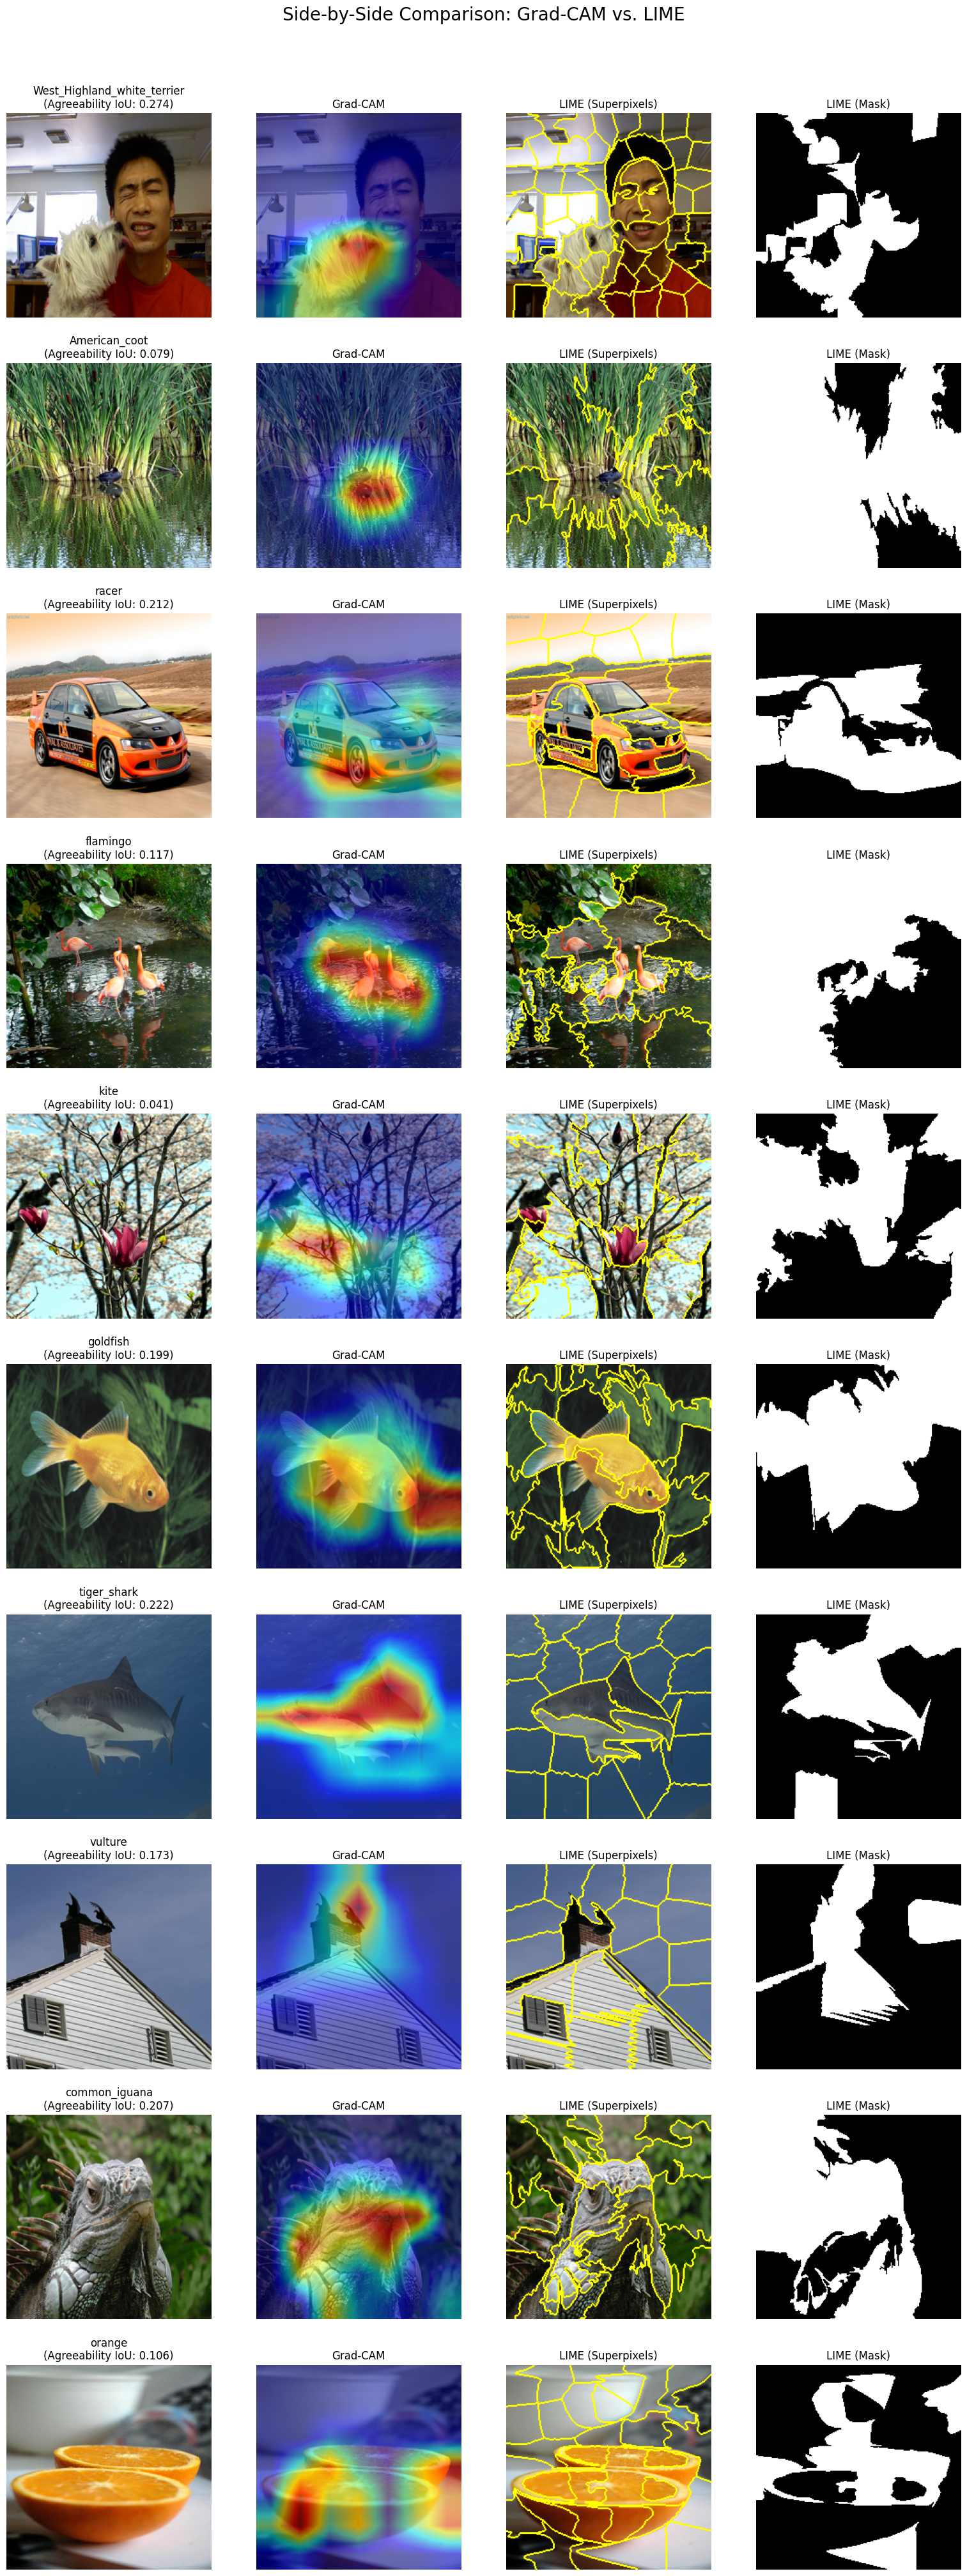


--- Summary of Agreeability IoU Scores ---
West_Highland_white_terrier   : 0.274
American_coot                 : 0.079
racer                         : 0.212
flamingo                      : 0.117
kite                          : 0.041
goldfish                      : 0.199
tiger_shark                   : 0.222
vulture                       : 0.173
common_iguana                 : 0.207
orange                        : 0.106


In [1]:
# Initialize Shared Model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
model.eval()

# Initialize LIME Analyzer with the shared model
lime_analyzer = LIMEAnalyzer(model=model)

# Initialize Grad-CAM with the shared model (From Task 2)
target_layers_grad_cam = [model.layer4[-1]]
grad_cam_model = GradCAM(model=model, target_layers=target_layers_grad_cam)


# Prepare data and statistics (from Task 3)
image_metadata = load_image_metadata()
print("Computing Complexity Statistics for LIME...")
ed_p50, ed_p75, cv_p50, cv_p75 = compute_images_statistics(image_metadata)
print("Setup complete. Starting analysis...")


# Visualize Plots - Main Loop
fig, axes = plt.subplots(10, 4, figsize=(16, 40))
fig.suptitle('Side-by-Side Comparison: Grad-CAM vs. LIME', fontsize=20, y=1.01)

# Keep track of IoU scores
iou_scores = {}

for idx, (image_name, metadata) in enumerate(image_metadata.items()):
    image = metadata["image"]
    print(f"\nProcessing [{image_name}]...")

    # 1. Generate LIME Explanation (Task 3)
    lime_result = lime_analyzer.generate_explanation(image, ed_p50, ed_p75, cv_p50, cv_p75)
    lime_mask = lime_result['mask']
    predicted_class = lime_result['predicted_class']
    lime_viz = mark_boundaries(lime_result['highlighted_image'] / 255.0, lime_result['segments'])

    # 2. Generate Grad-CAM Explanation (Task 2)
    rgb_img_for_viz = np.array(image.resize((224, 224))) / 255.0
    input_tensor = lime_analyzer.transform(image).unsqueeze(0).to(device)

    targets_for_grad_cam = [ClassifierOutputTarget(predicted_class)]
    grad_cam_heatmap = grad_cam_model(input_tensor=input_tensor, targets=targets_for_grad_cam)[0, :]
    grad_cam_viz = show_cam_on_image(rgb_img_for_viz, grad_cam_heatmap, use_rgb=True)

    # 3. Calculate IoU 
    grad_cam_threshold = 0.5  # This is the chosen threshold for binarizing the heatmap
    binary_grad_cam_mask = grad_cam_heatmap > grad_cam_threshold

    iou_score = calculate_iou(lime_mask, binary_grad_cam_mask)
    iou_scores[image_name] = iou_score
    print(f"--> Agreeability IoU (LIME vs. Grad-CAM @ 0.5): {iou_score:.3f}")

    # 4. Plotting
    axes[idx, 0].imshow(image.resize((224, 224)))
    axes[idx, 0].set_title(f"{image_name}\n(Agreeability IoU: {iou_score:.3f})")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(grad_cam_viz)
    axes[idx, 1].set_title("Grad-CAM")
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(lime_viz)
    axes[idx, 2].set_title("LIME (Superpixels)")
    axes[idx, 2].axis('off')

    axes[idx, 3].imshow(lime_mask, cmap='gray')
    axes[idx, 3].set_title("LIME (Mask)")
    axes[idx, 3].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

# Print IoU Scores
print("\n--- Summary of Agreeability IoU Scores ---")
for name, score in iou_scores.items():
    print(f"{name:<30}: {score:.3f}")